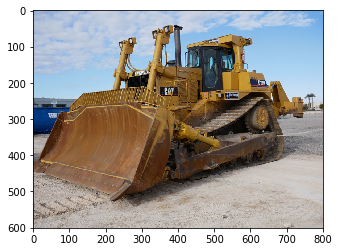

(601, 800, 3)
(800, 3)
[[113 154 206]
 [116 157 209]
 [117 159 209]
 [113 155 205]
 [109 150 204]]


In [70]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as immg

img = immg.imread('./data/bulld.jpg')
plt.imshow(img)
plt.show()

print(img.shape)
print(img[0].shape)
print(img[0][:5])

In [5]:

def assess_output_vol(input_size, fi, s, padd, K):
    """
        Computes the suitable output volume given S, F, P and K
        Assumes a square filter
    """

    on_h_axis = (input_size[0]-fi + 2*padd[0])/(s) + 1
    assert on_h_axis == int(on_h_axis), "The height axis requires padding : {}".format(on_h_axis)
    on_w_axis = (input_size[1]-fi + 2*padd[1])/(s) + 1
    assert on_w_axis == int(on_w_axis),"The width axis requires padding : {}".format(on_w_axis)
    on_d_axis = K
    #print(f'The dimensions of the output volume are \
    #    {on_h_axis} by {on_w_axis} by {on_d_axis}.')
    return (int(on_h_axis), int(on_w_axis), on_d_axis)

def convolutional_layer1(img, filter_size, stride, padding, K):
    """
        Receives a image (H*W*3)
        The kernel size is filter_size*filter_size*3
        The weights are learned by the CNN where each "slice" is a filter
        The depth of the output map is represented by K

        Returns:
            Activation map applying the filter to the input
    """
    weights = np.random.rand(K, filter_size, filter_size, img.shape[2])
    biases = np.random.rand(K, 1)
    print(f'The weights shape is {weights.shape} and biases shape is {biases.shape}')
    #print(weights[0,:,:,:].shape) # filter0 or weight0

    out_dims = assess_output_vol(img.shape, filter_size, stride, padding, K)
    activation_map = np.zeros(out_dims)
    assert activation_map.shape == out_dims

    for d in range(out_dims[2]):
        for i in range(0,img.shape[0]-filter_size,stride):
            for j in range(0,img.shape[1]-1*filter_size,stride):
                #assert img[i:i+filter_size,j:j+filter_size,:].shape == weights[d,:,:,:].shape, "Mismatch of shapes when i={},j={}".format(i,j)
                activation_map[int(i/stride),int(j/stride),d] = np.sum(img[i:i+filter_size,j:j+filter_size,:] * weights[d,:,:,:]) + biases[d]
    
    print(f'The output volume\'s shape is {activation_map.shape}\n')

    return activation_map

K = 10 # depth of output map

# Testing for suitable strides and Filter size combinations
assess_output_vol((11,11,3), 5, 2, [0,0], K)
assess_output_vol((img.shape[0]-1,img.shape[1],img.shape[2]), 22, 4, [1,1], K) # adding 1 pixel in H and 1 of padding to each side
# Passing the image through a basic convolution layer
adjusted_img = img
padd_h = np.zeros((1, adjusted_img.shape[1], adjusted_img.shape[2]))
adjusted_img = np.concatenate((adjusted_img, padd_h),axis=0)
padd_w = np.zeros((adjusted_img.shape[0],2,adjusted_img.shape[2]))
adjusted_img = np.concatenate((adjusted_img, padd_w),axis=1)
print(f'The adjusted shape is {adjusted_img.shape} compared to the initial shape {img.shape}')

activn_map_conv = convolutional_layer1(adjusted_img, 22, 4, [0,0], K)

The adjusted shape is (602, 802, 3) compared to the initial shape (601, 800, 3)
The weights shape is (10, 22, 22, 3) and biases shape is (10, 1)
The output volume's shape is (146, 196, 10)



In [17]:
def find_volume_pooling(input_size, F, S):
    """
        Given the input size (H,W,D) it calculates 
            the output volume (H',W',D) by the pooling operation
    """
    on_h_axis = (input_size[0] - F)/(S) + 1
    assert on_h_axis == int(on_h_axis), "The height axis requires padding : {}".format(on_h_axis)
    on_w_axis = (input_size[1] - F)/(S) + 1
    assert on_w_axis == int(on_w_axis),"The width axis requires padding : {}".format(on_w_axis)
    on_d_axis = input_size[2] # assuming (H,W,D)

    return (int(on_h_axis), int(on_w_axis), on_d_axis)

def pooling_layer1(input, F, S):
    """
        The basic intuition is very similar to the Convolutional layer
            expect it doesn't require weights or biases
        The goal here is to reduce the is to "compress" the input volume by
            discarding everything other than the maximum over a F * F area
        The most common way to compress is to use a MAX operation over each filter slice

    """
    
    out_dims = find_volume_pooling(input.shape, F, S)
    pooling_out = np.zeros(out_dims)

    for d in range(input.shape[2]):
        for i in range(0, input.shape[0],S):
            for j in range(0, input.shape[1],S):
                # Implementing the MAX-Pooling operation
                pooling_out[int(i/S),int(j/S),d] = np.max(input[i:i+F,j:j+F,d])
    
    print(f'The output volume shape is {pooling_out.shape}\n')

    return pooling_out


F=2 # filter size by convention
S=2 # stride by convention

# Testing the output volume
find_volume_pooling((224,224,64), F, S)
find_volume_pooling((146,196,10), F, S)

# adding zero padding to height - it is irrelevant to which part
input_pooling = activn_map_conv

out_pooling = pooling_layer1(input_pooling, F, S)

The output volume shape is (73, 98, 10)



In [7]:
# Reducing the input volume to a smaller dimension
# Typically this process is interchanged by several Convolutions layers to extract features at different levels

# Adding padding to the pooling output #1
adjusted_input = out_pooling
padd_h = np.zeros((1, adjusted_input.shape[1], adjusted_input.shape[2]))
adjusted_pooling = np.concatenate((adjusted_input, padd_h),axis=0)
out_pooling2 = pooling_layer1(adjusted_pooling, F, S)
# Adding padding to the pooling output #2
adjusted_input2 = out_pooling2
padd_h = np.zeros((1, adjusted_input2.shape[1], adjusted_input2.shape[2]))
tmp = np.concatenate((adjusted_input2, padd_h),axis=0)
padd_w = np.zeros((tmp.shape[0],1,tmp.shape[2]))
adjusted_pooling2 = np.concatenate((tmp, padd_w),axis=1)
out_pooling3 = pooling_layer1(adjusted_pooling2, F, S)

The output volume shape is (37, 49, 10)

The output volume shape is (19, 25, 10)



In [8]:
import time

def generate_layer_weights_biases(input_shape):
    """
        Given the input volume it returns a randomly generated a M*M weigh s matrix and biases
            required to compute the fully_connected_layer neuron values.
    """
    num_neurons = input_shape[0]*input_shape[1]*input_shape[2]
    weights = np.random.rand(num_neurons, num_neurons)
    biases = np.random.rand((num_neurons))
    assert weights[0,:].shape == biases.shape, "The shapes of the weights and biases are different"
    """
    print(f'A sample of the weights related to the first layer\'s neuron')
    print(weights[0,:50])
    """
    return weights, biases

def fully_connected_layer1(input):
    """
        The fully connected layer as a connection to all input cells so we can we use M*M matrix 
            for the M layer neurons with M biases where M = H*W*D

        Return:
            The activation map for the fully connected layer
    """
    weights, biases = generate_layer_weights_biases(input.shape)
    flattened = input.flatten() # for np.array([[[1,2,3],[4,5,6]],[[7,8,9],[10,11,12]] we get [1  2  3  4  5  6  7  8  9 10 11 12]
    assert flattened.shape[0] == weights.shape[0], "The input and weights shapes are not equal"
    start = time.time()
    neuron_vals = (weights * flattened) + biases
    print(f'Time elapsed: {time.time() - start} s')
    
    return neuron_vals

# Testing the generate weights-biases function
_, _ = generate_layer_weights_biases(out_pooling3.shape)

# Computing the fully connected layer neuron values
#TODO test this operation 
fully_connected_layer1(out_pooling3)

Time elapsed: 0.1981639862060547 s


array([[1.31672682e+05, 3.78062962e+04, 7.03481536e+01, ...,
        9.06387637e+04, 1.01129706e+05, 2.08335882e+04],
       [4.25822142e+04, 8.11124057e+04, 1.20968984e+05, ...,
        2.33917214e+04, 9.82661383e+04, 8.06703951e+03],
       [1.50856395e+04, 9.12942815e+04, 2.38477981e+04, ...,
        1.15548794e+05, 6.66566680e+04, 5.97106697e+04],
       ...,
       [1.44349889e+04, 4.32519568e+04, 9.31695199e+03, ...,
        9.30801830e+04, 1.16011046e+05, 5.37516467e+04],
       [6.94269106e+03, 1.26954581e+05, 1.17279713e+05, ...,
        5.46247683e+04, 5.88568148e+04, 1.02156257e+05],
       [2.07408477e+04, 4.84396906e+04, 5.38133414e+04, ...,
        2.71320878e+04, 9.57814809e+04, 2.26852129e+04]])

The output volume shape is (450, 600, 3)

The output volume shape is (225, 300, 3)

The weights shape is (3, 2, 2, 3) and biases shape is (3, 1)
The output volume's shape is (450, 600, 3)

The output volume shape is (225, 300, 3)



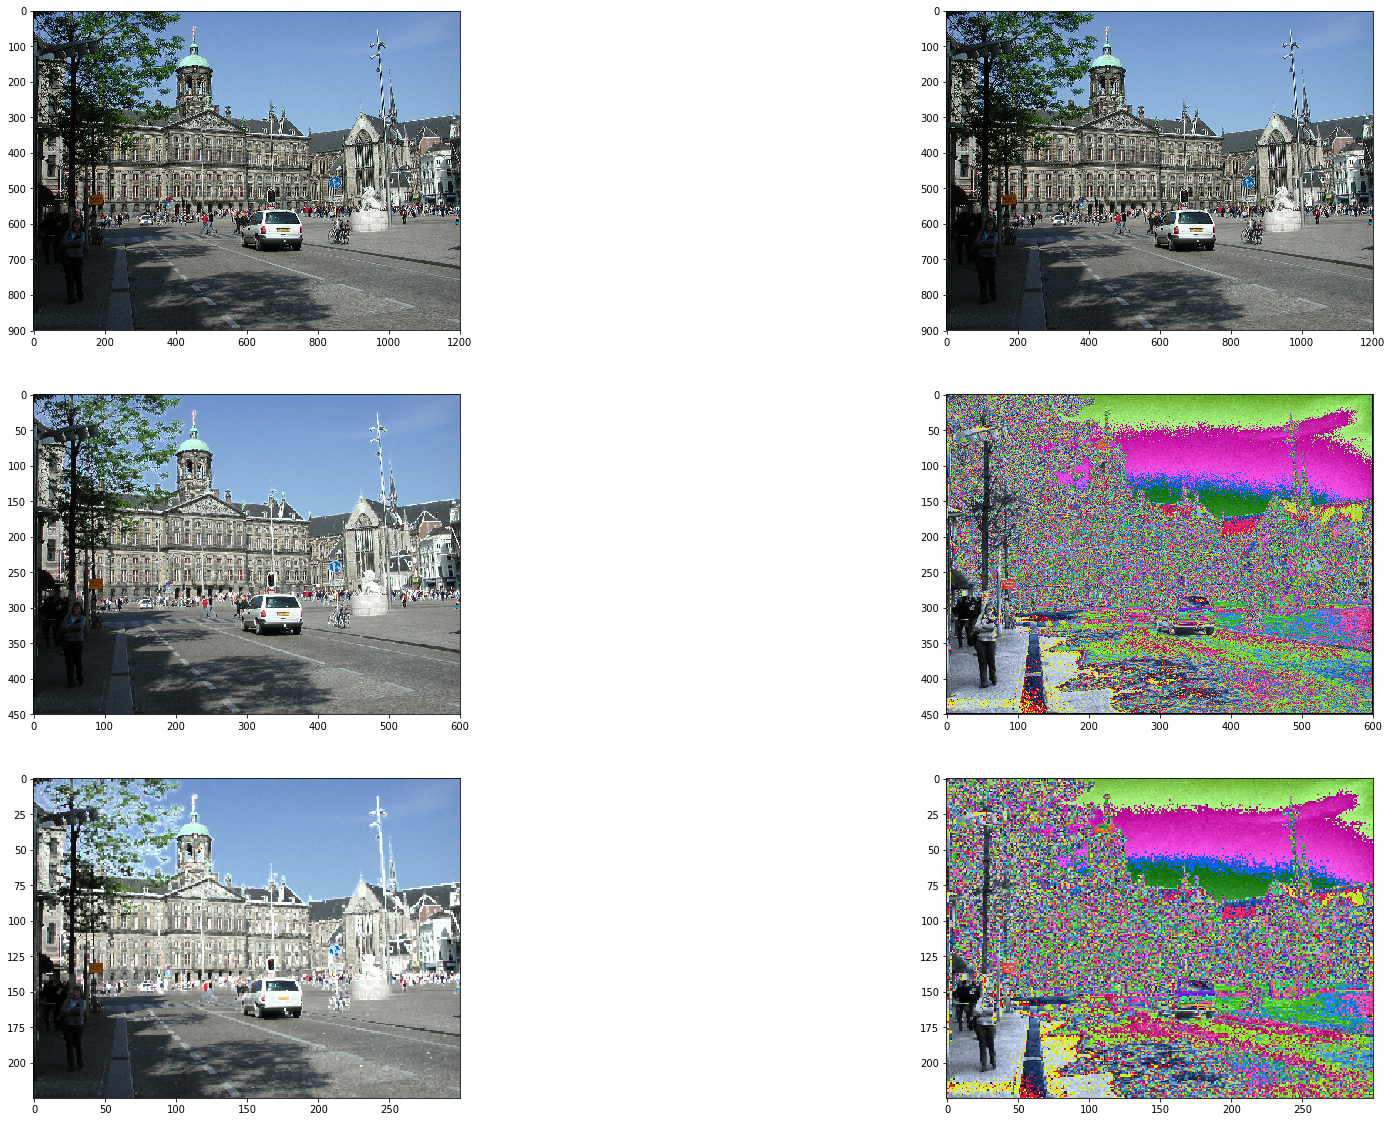

In [72]:
# Testing max pooling operation

def rgb2gray(rgb):
    """
        It converts from the 3 channels input image to 
            a RGB approximation using the 3 coefficients specified
    """
    gray = np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    gray_img = np.zeros((gray.shape[0], gray.shape[1], 1))
    gray_img[:,:,0] = gray
    return gray_img


dam =  immg.imread('./data/dam_square.jpg')

"""
# Gray scale Original image
gray_img = rgb2gray(dam)
plt.imshow(gray_img[:,:,0])
plt.show()

#After first pooling
dam_pooling = pooling_layer1(gray_img, F=2, S=2)
plt.imshow(dam_pooling[:,:,0])
plt.show()

#After second pooling
dam_pooling2 = pooling_layer1(dam_pooling, F=2, S=2)
plt.imshow(dam_pooling2[:,:,0])
plt.show()
"""

rows = 3
columns = 2
fig = plt.figure(figsize=(30, 20))

# Original image
fig.add_subplot(rows, columns, 1)
plt.imshow(dam)

#After first pooling
dam_pooling = pooling_layer1(dam, F=2, S=2)
fig.add_subplot(rows, columns, 3)
plt.imshow(dam_pooling.astype('uint8'))

#After second pooling
dam_pooling2 = pooling_layer1(dam_pooling, F=2, S=2)
fig.add_subplot(rows, columns, 5)
plt.imshow(dam_pooling2.astype('uint8'))

#After fully connected
# fully_connected_layer1(out_pooling3) Not possible due to huge memory requirements

############ 2nd column

# Original image
fig.add_subplot(rows, columns, 2)
plt.imshow(dam)

#After convolution
dam_conv3 = convolutional_layer1(dam, filter_size=2, stride=2, padding=[0,0], K=dam.shape[2])
fig.add_subplot(rows, columns, 4)
plt.imshow(dam_conv3.astype('uint8'))

#After pooling
dam_pooling3 = pooling_layer1(dam_conv3, F=2, S=2)
fig.add_subplot(rows, columns, 6)
plt.imshow(dam_pooling3.astype('uint8'))

#After Fully connected
# fully_connected_layer1(out_pooling3) Not possible due to huge memory requirements

plt.show()

In [1]:
# TODO 
# Change the loops to vectorized operations
# Implement 1x1 convolution variant
# Implement Dilated convolution
# Perform backpropagation on Convolutional operation (data and weights) and on Pooling operation
# Conversion from fully connected layer to CONV layer and vice-versa
# Explore doing a small autograd engine where both pooling and convolutional layers are applied sequentially